# Making Simulation Inputs for Cathodes from Images In a MATLAB Structure

Particle distribution generation from the images is handled by the distgen package, which can be found at [here](https://colwyngulliford.github.io/distgen/). The goal of this notebook is using the `distgen` package along with the `ProfmonImage` class to read MATLAB data files that contain images and image metadata and output cathode particle distributions to be used in programs like ImpactT and General Particle Tracer (GPT). It should be noted that the example MATLAB file is a minimum working example. The structure only includes the fields necessary for producing the distribution - the image as well as the number of pixels and pixel size (in microns) of the image in x and y. There may be many more fields included.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import pandas as pd
import imageio as iio
from distgen import Generator

from ProfmonImage import ProfmonImage
import pyPartAnalysis.read as rd
import pyPartAnalysis.convert as cv
import pyPartAnalysis.twiss as tw
import pyPartAnalysis.plot as ppa_plt

The `distgen` package uses yaml or yml files with distribution properties as inputs to create the distributions. Below we include a function that writes a yaml file for a 20480 particle distribution created from a 2D image. The user provides the x and y extents of the image. The function can be modified to suit the final distribution, e.g. changing the total charge, mean transverse energy (MTE) to match measured emittances, and pulse duration.

In [2]:
def write_yaml_distgen(yaml_file_name,image_file_name,extent_x,extent_y,threshold):
    # writes sample yaml input file for distgen
    
    yaml_dict =   {  'n_particle': 20480,
                 'random': {
                     'type': 'hammersley'},
                 'start': {
                     'MTE': {
                         'units': 'meV', 
                         'value': 1000}, 
                     'type': 'cathode'},
                 'total_charge': {
                     'units': 'pC', 
                     'value': 5.15},
                 'xy_dist': {
                     'file': image_file_name,
                     'max_x': {
                         'units': 'mm', 
                         'value': extent_x[1].item()*1e3},
                     'max_y': {
                         'units': 'mm', 
                         'value': extent_y[1].item()*1e3},
                     'min_x': {
                         'units': 'mm', 
                         'value': extent_x[0].item()*1e3},
                     'min_y': {
                         'units': 'mm',
                         'value': extent_y[0].item()*1e3},
                     'threshold': threshold,
                     'type': 'file2d'},
                   't_dist': {
                       'avg_t': {
                           'units': 'fs',
                           'value': 0},
                       'sigma_t': {
                           'units': 'fs', 
                           'value': 200/2.355},
                       'type': 'gaussian'}}
    
    with open(yaml_file_name, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

# Load MATLAB Struct using `ProfmonImage` Class

The `ProfmonImage` class reads in a image stored in a MATLAB structure and has many capabilities such as plotting and calculating the bounds of the image.

In [3]:
obj = ProfmonImage('ProfMon-Example.mat')

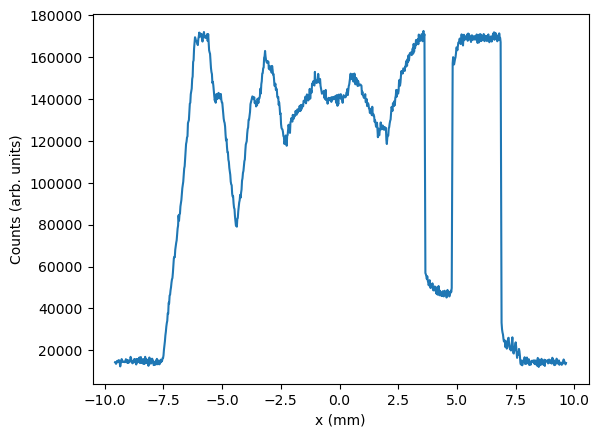

In [4]:
_ = obj.plot_profile('x')

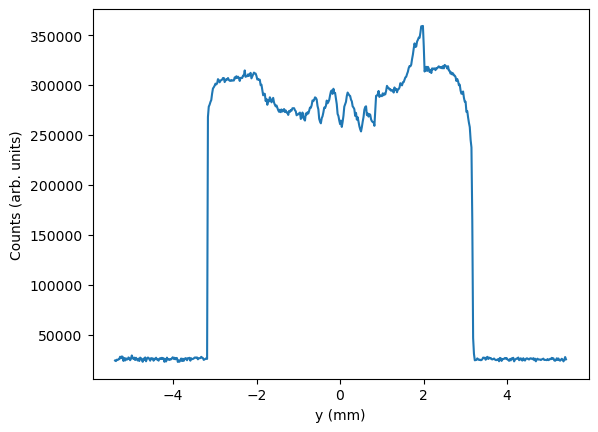

In [5]:
_ = obj.plot_profile('y')

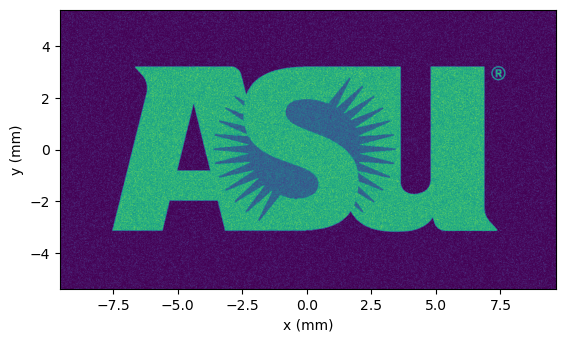

In [6]:
_ = obj.plot()

It also has the ability to save the image stored in the MATLAB structure as a separate image for reading in by `distgen`.

In [7]:
obj.save("cathode.png")

## Read in image for benchmarking

We check that the image was written correctly by reading it back and displaying it in the notebook.

In [8]:
im = iio.v3.imread('cathode.png')

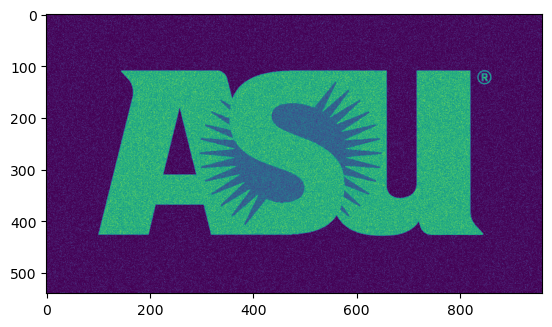

In [9]:
plt.imshow(im);

# Making Distribution Using `distgen`

Now that we know the image was written correctly, we write the yaml file and have `distgen` generate the distribution for examination.

In [10]:
write_yaml_distgen(yaml_file_name='cathode.yml',
                   image_file_name='cathode.png',
                   extent_x=[obj.min_x,obj.max_x],
                   extent_y=[obj.min_y,obj.max_y],
                   threshold=0.00)

In [11]:
gen = Generator('cathode.yml')

In [12]:
pg = gen.run()

We plot the real space image for examination; we find that there are excessive particles outside the laser profile, i.e. there may be some noise that needs to be removed. For ImpactT, leaving them will cause the bounds of the grid to be unnecessarily large, increasing the size of the space charge grid bins and possibly requiring us to increase the grid resolution and thus computation time.

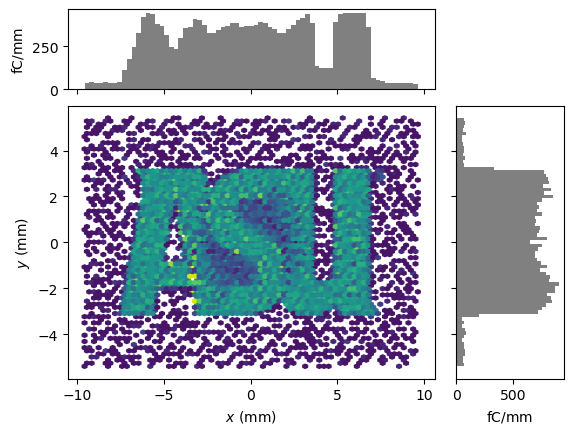

In [13]:
pg.plot('x', 'y')

We can remove these particles be increasing the threshold value until just the non-background portion of the image remains.

In [14]:
write_yaml_distgen(yaml_file_name='cathode.yml',image_file_name='cathode.png',extent_x=[obj.min_x,obj.max_x],extent_y=[obj.min_y,obj.max_y],threshold=0.32)

In [15]:
gen = Generator('cathode.yml')

In [16]:
pg = gen.run()

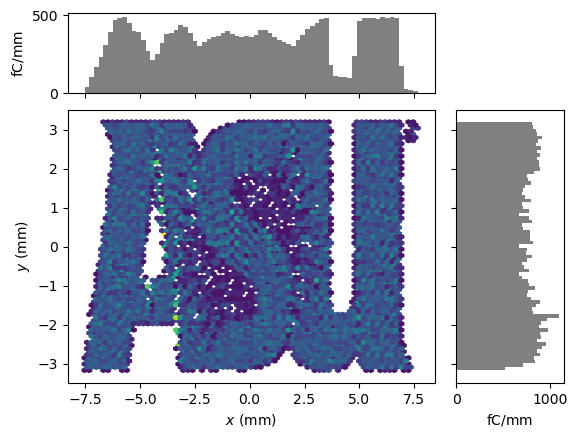

In [17]:
pg.plot('x', 'y')

We also plot the x phase space to see how they handle momentum - we can see the x momentum has a gaussian spread.

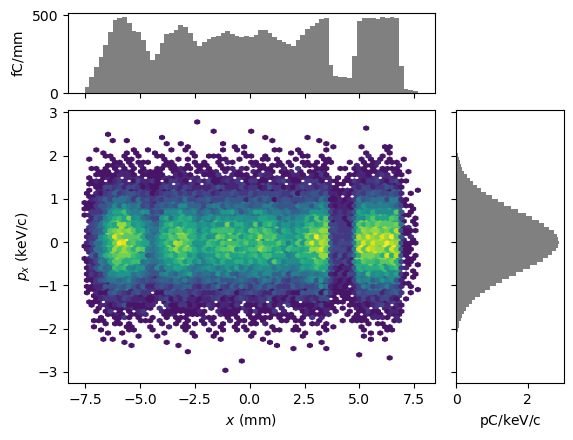

In [18]:
pg.plot('x', 'px')

## Write OpenPMD beam physics particle group objects to Impact-T Input File

Now that the distribution is to our liking we can write it to file. To output the distribution, we follow the examples [here](https://github.com/ChristopherMayes/openPMD-beamphysics/blob/master/docs/examples/write_examples.ipynb).

In [19]:
pg.write_gpt('vcc_gpt.txt')

ASCII particles written. Convert to GDF using: asci2df -o particles.gdf vcc_gpt.txt


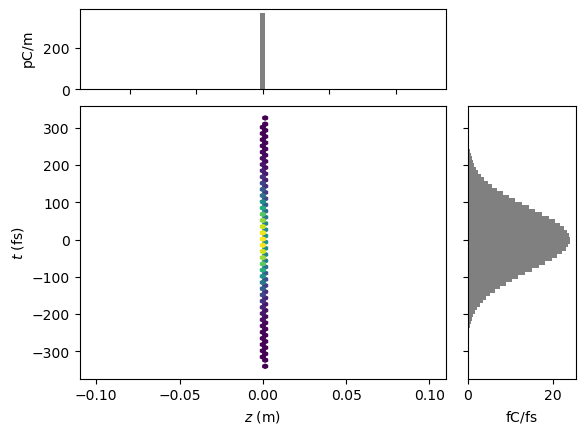

In [20]:
pg.plot('z', 't')

For ImpactT, we all the particles at the same step, which requires the call to the `drift_to_t` function before writing. 

In [21]:
pg.drift_to_t(pg['mean_t'])

In [22]:
pg.write_impact('partcl.data_20k')

{'input_particle_file': 'partcl.data_20k',
 'Np': 20480,
 'Tini': -1.0100232814706253e-30,
 'Flagimg': 0}

# Benchmarking ImpactT Output

Now that the distribution is written to file, we read the ImpactT distribution back in to check if the results are as expected.

## Read in Impact-T Distribution

In [23]:
df_GB = rd.read_GB(filename='partcl.data_20k',skiprows=1)

In [24]:
df_PS = cv.GB_to_phase_space(df_GB)

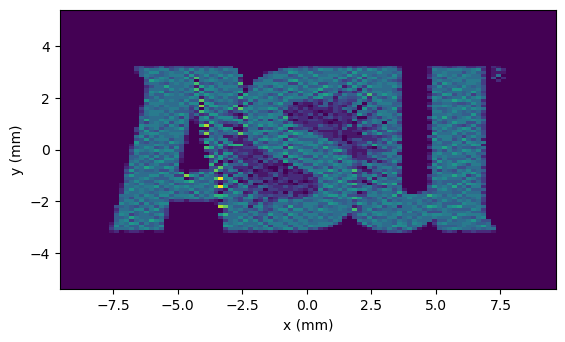

In [25]:
fig, ax = plt.subplots()
ax.axis('square')
_ = ppa_plt.plot_transverse_density(df_PS,[100,100],ax=ax,range=np.array(obj.extent())*1e3)

The distribution matches the prior images.

## Calculate Emittance per radius

For emission from a cathode, an important quantity is the thermal emittance or the emittance of the beam before RF fields or space charge forces have a chance to cause degredation. Often it we be refered to as the ratio $\epsilon_n/\sigma$ or the normalized emittance per RMS beam size. It can be calculated analytically using either laser and RF parameters (see [Dowell and Schmerge, 2009](https://doi.org/10.1103/PhysRevSTAB.12.074201)):

\begin{equation}
\frac{\epsilon_n}{\sigma} = \sqrt{\frac{\hbar\omega-\phi_{eff}}{3mc^2}}
\end{equation}

where $\hbar\omega$ is the photon energy of the aprticular wavelength of laser used in eV and $mc^2$ is the rest mass of an electron (0.511 MeV). The effective work function $\phi_{eff}$ or the energy needed to overcome the energy barrier near the cathode surface is given by

\begin{equation}
\begin{aligned}
\phi_{eff} &= \phi_{w} - \phi_{Schottky} = \phi_{w} - e \sqrt{\frac{eF_a}{4\pi\epsilon_0}}\\[10pt]
&= \phi_{w} - 0.037947 \sqrt{F_a (MV/m)} eV
\end{aligned}
\end{equation}

where $\phi_{w}$ is the work function (which depends on the cathode material - [it is 4.31 eV for atomically clean copper](https://doi.org/10.1103/PhysRevSTAB.9.063502)) and $\phi_{Schottky}$ is the height of the photoemission potential barrier just outside the cathode. At higher field amplitudes at the cathode surface $F_a$, the barrier is reduced.

As the thermal emittance is also related to the [mean transverse energy (MTE)](https://en.wikipedia.org/wiki/Mean_transverse_energy) via

\begin{equation}
\frac{\epsilon_n}{\sigma} = \sqrt{\frac{MTE}{mc^2}},
\end{equation}

we can calculate this value given the MTE we used in the input file.

We previously set this to 1000 meV in the `distgen` input file, which ends up giving us 1.3989 mm-mrad per mm from the above equation. A value of 0.5 is highly idealized while values of 1 or greater are more realistic. The value can be higher depending on the roughness of the cathode surface.

Checking that we get a similar ratio we calculate the emittance and RMS size directly from the distribution:

In [26]:
twiss_data = tw.get_twiss_parameters(df_GB)

In [27]:
print(twiss_data)

emitn = [5.783064345551445e-06, 2.619417785557677e-06, 2.996694432203799e-11]
emit = [0.005180344143385059, 0.002346417880501458, 2.684374152489441e-08]
alpha = [0.0005035566572578315, -0.0002817009288986158, -0.00027651571544592935]
beta = [2.954996263719434, 1.3384544868358192, 4.216233024668793e-05]
gamma = [0.3384099891587049, 0.747130432293943, 23717.855977362546]



In [28]:
twiss_data.x().emitn()*1e6/(df_PS.std().x*1e3)

1.398944690198756

In [29]:
twiss_data.y().emitn()*1e6/(df_PS.std().y*1e3)

1.3989448120565438

We can see that we get a matching value of 1.3989 mm-rad per mm.